In [755]:
import pandas as pd
pd.set_option('display.max_columns', None)

df = pd.read_csv("source.csv")
df.drop(["Unnamed: 0"], axis=1, inplace=True)
df.head()

,characteristincs_balcony,characteristincs_yard,characteristincs_rooftop,characteristincs_garage,amenities_amoblado,amenities_cancha_paddle,amenities_cancha_tenis,amenities_gimnasio,amenities_hidromasaje,amenities_laundry,amenities_microcine,amenities_parrilla,amenities_piscina,amenities_sala_de_juegos,amenities_sauna,amenities_solarium,amenities_spa,amenities_sum,amenities_estacionamiento_visitas,antiquity,price,ambience,bedrooms,bathrooms,surface_total,centros_comerciales_cercanos,parques_cercanos,escuelas_cercanas,location_neighbourhood_Abasto,location_neighbourhood_Agronomía,location_neighbourhood_Almagro,location_neighbourhood_Almagro Norte,location_neighbourhood_Almagro Sur,location_neighbourhood_Balvanera,location_neighbourhood_Congreso,location_neighbourhood_Once,location_neighbourhood_Barracas,location_neighbourhood_Barrio Norte,location_neighbourhood_La isla,location_neighbourhood_Parque las Heras,location_neighbourhood_Recoleta,location_neighbourhood_Belgrano,location_neighbourhood_Belgrano Barrancas,location_neighbourhood_Belgrano C,location_neighbourhood_Belgrano La Imprenta,location_neighbourhood_Belgrano R,location_neighbourhood_Boedo,location_neighbourhood_Caballito,location_neighbourhood_Caballito Barrio Ingles,location_neighbourhood_Caballito Cid Campeador,location_neighbourhood_Caballito Norte,location_neighbourhood_Caballito Parque Rivadavia,location_neighbourhood_Caballito Primera Junta,location_neighbourhood_Caballito Sur,location_neighbourhood_Chacarita,location_neighbourhood_Coghlan,location_neighbourhood_Colegiales,location_neighbourhood_Constitución,location_neighbourhood_Flores,location_neighbourhood_Flores Norte,location_neighbourhood_Flores Sur,location_neighbourhood_Floresta,location_neighbourhood_Floresta Norte,location_neighbourhood_Floresta Sur,location_neighbourhood_La boca,location_neighbourhood_La paternal,location_neighbourhood_Liniers,location_neighbourhood_Mataderos,location_neighbourhood_Microcentro,location_neighbourhood_Monserrat,location_neighbourhood_Monte Castro,location_neighbourhood_Nuñez,location_neighbourhood_Nuñez Lomas,location_neighbourhood_Nuñez River,location_neighbourhood_Palermo,location_neighbourhood_Palermo Botánico,location_neighbourhood_Palermo Boulevard,location_neighbourhood_Palermo Chico,location_neighbourhood_Palermo Hollywood,location_neighbourhood_Palermo Las Cañitas,location_neighbourhood_Palermo Pacífico,location_neighbourhood_Palermo Plaza Italia,location_neighbourhood_Palermo Soho,location_neighbourhood_Palermo Viejo,location_neighbourhood_Parque Avellaneda,location_neighbourhood_Parque Centenario,location_neighbourhood_Parque Chacabuco,location_neighbourhood_Parque Chas,location_neighbourhood_Parque Patricios,location_neighbourhood_Pompeya,location_neighbourhood_Primera Junta,location_neighbourhood_Puerto Madero,location_neighbourhood_Retiro,location_neighbourhood_Retiro Catalinas,location_neighbourhood_Retiro Plaza San Martín,location_neighbourhood_Saavedra,location_neighbourhood_San Cristobal,location_neighbourhood_San Nicolas,location_neighbourhood_Tribunales,location_neighbourhood_San Telmo,location_neighbourhood_Velez Sarsfield,location_neighbourhood_Versalles,location_neighbourhood_Villa Crespo,location_neighbourhood_Villa del Parque,location_neighbourhood_Villa Devoto,location_neighbourhood_Villa General Mitre,location_neighbourhood_Villa Lugano,location_neighbourhood_Villa Luro,location_neighbourhood_Villa Ortuzar,location_neighbourhood_Villa Pueyrredon,location_neighbourhood_Villa Real,location_neighbourhood_Villa Riachuelo,location_neighbourhood_Villa Santa Rita,location_neighbourhood_Villa Soldati,location_neighbourhood_Villa Urquiza
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,70.422535,2.0,1.0,1,35,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,95.774648,3.0,2.0,1,70,0,0,0,

<Axes: xlabel='surface_total', ylabel='price'>

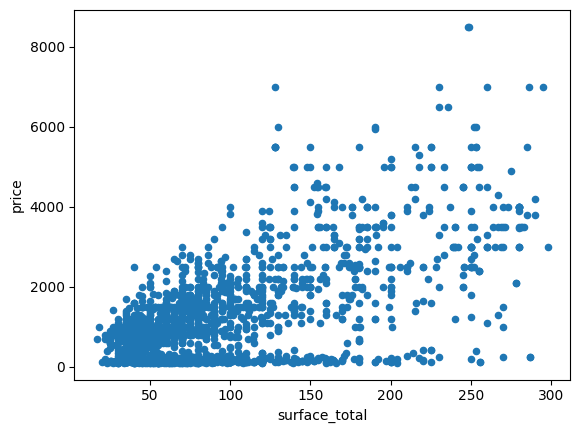

In [756]:
# Tenemos varios outliers en relación a superficie de los departamentos

#df = df.loc[df.price > 100]
#df = df.loc[df.surface_total < 300]

# Precio por superficie
var = 'surface_total'
data = pd.concat([df['price'], df[var]], axis=1)
data.plot.scatter(x=var, y='price')

In [757]:
df.price.describe()

count    2084.000000
mean     1183.405809
std      1230.556048
min       100.000000
25%       169.014085
50%       880.000000
75%      1600.000000
max      8500.000000
Name: price, dtype: float64

In [758]:
from sklearn.model_selection import train_test_split
y = df.price
X = df.drop(["price"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Linear Regression

Se realizará un grid search sobre la regresión lineal para validar qué modelo mejor se aproxima

In [734]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

linear_regression = LinearRegression()
linear_regression_grid = dict()
linear_regression_grid['fit_intercept'] = [True, False]
linear_regression_grid['positive'] = [True, False]

# Definimos el procedimiento de grid search
linear_regression_grid_search = GridSearchCV(estimator=linear_regression, param_grid=linear_regression_grid, n_jobs=-1, verbose=2, cv=2)

# Ejecutamos el grid search
linear_regression_grid_result = linear_regression_grid_search.fit(X, y)

# Vemos el resultado
print("Best: %f using %s" % (linear_regression_grid_result.best_score_, linear_regression_grid_result.best_params_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] END .................fit_intercept=True, positive=False; total time=   0.0s
[CV] END ................fit_intercept=False, positive=False; total time=   0.0s
[CV] END ..................fit_intercept=True, positive=True; total time=   0.0s
[CV] END .................fit_intercept=False, positive=True; total time=   0.0s
[CV] END .................fit_intercept=False, positive=True; total time=   0.0s
[CV] END ..................fit_intercept=True, positive=True; total time=   0.0s
[CV] END ................fit_intercept=False, positive=False; total time=   0.0s
[CV] END .................fit_intercept=True, positive=False; total time=   0.0s
Best: 0.456055 using {'fit_intercept': False, 'positive': True}


In [735]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


best_linear_regression = LinearRegression(fit_intercept=False, positive=True)
best_linear_regression_model = best_linear_regression.fit(X_train, y_train)

best_linear_regression_pred = best_linear_regression_model.predict(X_test)
print("RMSE score is: " + str(mean_squared_error(y_test, best_linear_regression_pred, squared=False)))
print("Model score is: " + str(best_linear_regression_model.score(X_test, y_test)))

RMSE score is: 1082.5885999937702
Model score is: 0.44664061982298964


# Lasso Regression
Se realizará un grid search sobre la regresión Lasso para verificar los mejores resultados

In [736]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

lasso_regression = Lasso()
lasso_regression_grid = dict()
lasso_regression_grid['alpha'] = [0.0005, 0.005, 0.02, 0.03]

# Definimos el procedimiento de grid search
lasso_regression_grid_search = GridSearchCV(estimator=lasso_regression, param_grid=lasso_regression_grid, n_jobs=-1, verbose=2, cv=2)

# Ejecutamos el grid search
lasso_regression_grid_result = lasso_regression_grid_search.fit(X, y)

# Vemos el resultado
print("Best: %f using %s" % (lasso_regression_grid_result.best_score_, lasso_regression_grid_result.best_params_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] END .......................................alpha=0.0005; total time=   0.1s
[CV] END ........................................alpha=0.005; total time=   0.1s
[CV] END .......................................alpha=0.0005; total time=   0.1s
[CV] END .........................................alpha=0.02; total time=   0.0s
[CV] END ........................................alpha=0.005; total time=   0.1s
[CV] END .........................................alpha=0.03; total time=   0.0s
[CV] END .........................................alpha=0.03; total time=   0.0s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.556e+08, tolerance: 9.135e+04
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.439e+08, tolerance: 9.135e+04
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.098e+07, toleranc

[CV] END .........................................alpha=0.02; total time=   0.1s
Best: 0.476537 using {'alpha': 0.03}


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.035e+07, tolerance: 1.587e+05
  model = cd_fast.enet_coordinate_descent(


In [739]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error


best_lasso_regression = Lasso(alpha=0.03)
best_lasso_regression_model = best_lasso_regression.fit(X_train, y_train)

best_lasso_regression_pred = best_lasso_regression_model.predict(X_test)
print("RMSE score is: " + str(mean_squared_error(y_test, best_lasso_regression_pred, squared=False)))
print("Model score is: " + str(best_lasso_regression_model.score(X_test, y_test)))

RMSE score is: 1057.1686510379825
Model score is: 0.47232207084507183


# Elastic Net regression
Realizaremos un grid search sobre los parámetros de elastic net para buscar el mejor resultado.

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

enet_regression = ElasticNet()
enet_regression_grid = dict()
enet_regression_grid['alpha'] = [0.0005, 0.005, 0.02, 0.03]
enet_regression_grid['l1_ratio'] = [0.01, 0.001, 0.1, 0.5]

# Definimos el procedimiento de grid search
enet_regression_grid_search = GridSearchCV(estimator=enet_regression, param_grid=enet_regression_grid, n_jobs=-1, verbose=2, cv=2)

# Ejecutamos el grid search
enet_regression_grid_result = enet_regression_grid_search.fit(X, y)

# Vemos el resultado
print("Best: %f using %s" % (enet_regression_grid_result.best_score_, enet_regression_grid_result.best_params_))

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error


best_enet_regression = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)
best_enet_regression_model = best_enet_regression.fit(X_train, y_train)

best_enet_regression_pred = best_enet_regression_model.predict(X_test)
print("RMSE score is: " + str(mean_squared_error(y_test, best_enet_regression_pred, squared=False)))
print("Model score is: " + str(best_enet_regression_model.score(X_test, y_test)))

# Kernel Ridge
Se realizará un grid search para revisar los mejores hiperparámetros para utilizar con Kernel Ridge

In [ ]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

krr = KernelRidge()
krr_grid = dict()
krr_grid['alpha'] = [0.0005, 0.005, 0.02, 0.03]
krr_grid['degree'] = [1, 2, 6]
krr_grid['coef0'] = [0.1, 1, 2.5]
krr_grid['kernel'] = ['linear', 'polynomial']


# Definimos el procedimiento de grid search
krr_grid_search = GridSearchCV(estimator=krr, param_grid=krr_grid, n_jobs=-1, verbose=2, cv=2)

# Ejecutamos el grid search
krr_grid_result = krr_grid_search.fit(X, y)

# Vemos el resultado
print("Best: %f using %s" % (krr_grid_result.best_score_, krr_grid_result.best_params_))

In [ ]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error


best_krr = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
best_krr_model = best_krr.fit(X_train, y_train)

best_krr_pred = best_krr_model.predict(X_test)
print("RMSE score is: " + str(mean_squared_error(y_test, best_krr_pred, squared=False)))
print("Model score is: " + str(best_krr_model.score(X_test, y_test)))

# Random Forest
Busqueda de mejores hiperparámetros para utilización de Random Forest.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor()
rf_grid = dict()
rf_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['squared_error', 'absolute_error', 'poisson']
}


# Definimos el procedimiento de grid search
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_grid, n_jobs=-1, verbose=2, cv=2)

# Ejecutamos el grid search
rf_grid_result = rf_grid_search.fit(X, y)

# Vemos el resultado
print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


best_rf = RandomForestRegressor(max_depth=2, random_state=0)
best_rf_model = best_rf.fit(X_train, y_train)

best_rf_pred = best_rf_model.predict(X_test)
print("RMSE score is: " + str(mean_squared_error(y_test, best_rf_pred, squared=False)))
print("Model score is: " + str(best_rf_model.score(X_test, y_test)))

# Bagging Regressor

Busqueda de hiperparametros para Bagging Regressor

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import GridSearchCV

bagging = BaggingRegressor()
bagging_grid = dict()
bagging_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.7, 0.9],
    'max_features': [0.5, 0.7, 0.9]
}


# Definimos el procedimiento de grid search
bagging_grid_search = GridSearchCV(estimator=bagging, param_grid=bagging_grid, n_jobs=-1, verbose=2, cv=2)

# Ejecutamos el grid search
bagging_grid_result = bagging_grid_search.fit(X, y)

# Vemos el resultado
print("Best: %f using %s" % (bagging_grid_result.best_score_, bagging_grid_result.best_params_))

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error


best_bagging = BaggingRegressor()
best_bagging_model = best_bagging.fit(X_train, y_train)

best_bagging_pred = best_bagging_model.predict(X_test)
print("RMSE score is: " + str(mean_squared_error(y_test, best_bagging_pred, squared=False)))
print("Model score is: " + str(best_bagging_model.score(X_test, y_test)))

# Ada Boost Regressor
Busqueda de mejores hiperparámetros para modelo Ada Boost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

ada = AdaBoostRegressor()
ada_grid = dict()
ada_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.7, 0.9],
    'max_features': [0.5, 0.7, 0.9]
}


# Definimos el procedimiento de grid search
ada_grid_search = GridSearchCV(estimator=ada, param_grid=ada_grid, n_jobs=-1, verbose=2, cv=2)

# Ejecutamos el grid search
ada_grid_result = ada_grid_search.fit(X, y)

# Vemos el resultado
print("Best: %f using %s" % (ada_grid_result.best_score_, ada_grid_result.best_params_))

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error


best_ada = AdaBoostRegressor()
best_ada_model = best_ada.fit(X_train, y_train)

best_ada_pred = best_ada_model.predict(X_test)
print("RMSE score is: " + str(mean_squared_error(y_test, best_ada_pred, squared=False)))
print("Model score is: " + str(best_ada_model.score(X_test, y_test)))

# SVM
Busqueda de hiperparámetros para mejor aproximación con SVM (SVR para regresión)

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svr = SVR()
svr_grid = dict()
svr_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']    
}


# Definimos el procedimiento de grid search
svr_grid_search = GridSearchCV(estimator=svr, param_grid=svr_grid, n_jobs=-1, verbose=2, cv=2)

# Ejecutamos el grid search
svr_grid_result = svr_grid_search.fit(X, y)

# Vemos el resultado
print("Best: %f using %s" % (svr_grid_result.best_score_, svr_grid_result.best_params_))

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error


best_svr = SVR()
best_svr_model = best_svr.fit(X_train, y_train)

best_svr_pred = best_svr_model.predict(X_test)
print("RMSE score is: " + str(mean_squared_error(y_test, best_svr_pred, squared=False)))
print("Model score is: " + str(best_svr_model.score(X_test, y_test)))

# Gradient Booster Regressor
Busqueda de mejores hiperparametos para Gradient Boosting

In [656]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

model = GradientBoostingRegressor()
grid = dict()
grid['random_state'] = [5]

grid['loss'] = ["squared_error", "absolute_error", "huber", "quantile"]
#grid['loss'] = ["absolute_error"]

grid['max_features'] = ["sqrt", "log2"]
#grid['max_features'] = ["sqrt"]

grid['n_estimators'] = [500, 1000, 3000, 5000]
#grid['n_estimators'] = [3000]

grid['min_samples_split'] = [2, 5, 7, 10, 15]
#grid['min_samples_split'] = [10]

grid['min_samples_leaf'] = [2, 5, 7, 10, 15]
#grid['min_samples_leaf'] = [15]

grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.05, 0.1]
#grid['learning_rate'] = [0.05]

grid['subsample'] = [0.5, 0.7, 1.0]
#grid['subsample'] = [1]

grid['max_depth'] = [3, 5, 7, 9]
#grid['max_depth'] = [4]


# Procedimiento de evaluación, utilizamos RepeatedKFold
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Definimos el procedimiento de grid search
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, verbose=2, cv=2)

# Ejecutamos el grid search
grid_result = grid_search.fit(X, y)

# Vemos el resultado
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END learning_rate=0.05, loss=absolute_error, max_depth=4, max_features=sqrt, min_samples_leaf=15, min_samples_split=10, n_estimators=3000, random_state=5, subsample=1; total time=   1.7s
[CV] END learning_rate=0.05, loss=absolute_error, max_depth=4, max_features=sqrt, min_samples_leaf=15, min_samples_split=10, n_estimators=3000, random_state=5, subsample=1; total time=   2.0s
Best: 0.496765 using {'learning_rate': 0.05, 'loss': 'absolute_error', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 15, 'min_samples_split': 10, 'n_estimators': 3000, 'random_state': 5, 'subsample': 1}


In [759]:
from sklearn.ensemble import GradientBoostingRegressor

# Con hiperparámetros probados

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state =15)
GBoost_model = GBoost.fit(X_train, y_train)

GBoost_pred = GBoost_model.predict(X_test)
print("RMSE score is: " + str(mean_squared_error(y_test, GBoost_pred, squared=False)))
print("Model score is: " + str(GBoost_model.score(X_test, y_test)))

RMSE score is: 863.8162691597695
Model score is: 0.48536569273829644


In [760]:
from sklearn.ensemble import GradientBoostingRegressor

# Con resultados del CVGridSearch

GBoost2 = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.01,
                                   max_depth=5, max_features='sqrt',
                                   min_samples_leaf=2, min_samples_split=15,
                                   loss='absolute_error', random_state = 5, subsample=0.5)
GBoost_model2 = GBoost2.fit(X_train, y_train)

GBoost_pred2 = GBoost_model2.predict(X_test)
print("RMSE score is: " + str(mean_squared_error(y_test, GBoost_pred2, squared=False)))
print("Model score is: " + str(GBoost_model2.score(X_test, y_test)))

RMSE score is: 830.6775664734831
Model score is: 0.5240942636414403


In [748]:
# Vamos a persistir el modelo que mejor nos dió

import pickle
from joblib import dump, load

dump(GBoost_model2, 'Models/gboost_model5.joblib')

['Models/gboost_model5.joblib']

In [659]:
columns_list = X_test.columns.tolist()
print(columns_list)

['characteristincs_balcony', 'characteristincs_yard', 'characteristincs_rooftop', 'characteristincs_garage', 'amenities_amoblado', 'amenities_cancha_paddle', 'amenities_cancha_tenis', 'amenities_gimnasio', 'amenities_hidromasaje', 'amenities_laundry', 'amenities_microcine', 'amenities_parrilla', 'amenities_piscina', 'amenities_sala_de_juegos', 'amenities_sauna', 'amenities_solarium', 'amenities_spa', 'amenities_sum', 'amenities_estacionamiento_visitas', 'antiquity', 'ambience', 'bedrooms', 'bathrooms', 'surface_total', 'centros_comerciales_cercanos', 'parques_cercanos', 'escuelas_cercanas', 'location_neighbourhood_Abasto', 'location_neighbourhood_Agronomía', 'location_neighbourhood_Almagro', 'location_neighbourhood_Almagro Norte', 'location_neighbourhood_Almagro Sur', 'location_neighbourhood_Balvanera', 'location_neighbourhood_Congreso', 'location_neighbourhood_Once', 'location_neighbourhood_Barracas', 'location_neighbourhood_Barrio Norte', 'location_neighbourhood_La isla', 'location_n